# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2020-09-14

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-09-14.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing day to day changes in reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 109 to 13688
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      38 non-null     datetime64[ns]
 1   Day                 38 non-null     object        
 2   Week                38 non-null     int64         
 3   Daily_delta         38 non-null     int64         
 4   Total_reported      38 non-null     int64         
 5   Deceased            38 non-null     float64       
 6   Deceased_delta      38 non-null     float64       
 7   Hospital_admission  38 non-null     int64         
 8   Hospital_delta      38 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 3.0+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
10385,2020-04-10,Friday,15,83,1087,68.0,2.0,345,2
10752,2020-04-11,Saturday,15,50,1137,75.0,7.0,353,8
11119,2020-04-12,Sunday,15,45,1182,82.0,7.0,355,2
11486,2020-04-13,Monday,16,30,1212,87.0,5.0,368,13
11853,2020-04-14,Tuesday,16,46,1258,94.0,7.0,400,32
12220,2020-04-15,Wednesday,16,27,1285,109.0,15.0,412,12
12587,2020-04-16,Thursday,16,55,1340,115.0,6.0,438,26
12954,2020-04-17,Friday,16,73,1413,121.0,6.0,452,14
13321,2020-04-18,Saturday,16,68,1481,123.0,2.0,457,5
13688,2020-04-19,Sunday,16,54,1535,129.0,6.0,471,14


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
2678,2020-03-20,12,110,195,15
10385,2020-04-10,15,83,1087,2
12954,2020-04-17,16,73,1413,14
8550,2020-04-05,14,69,887,17
5614,2020-03-28,13,68,483,25
13321,2020-04-18,16,68,1481,5
5247,2020-03-27,13,62,415,26
7449,2020-04-02,14,56,730,17
12587,2020-04-16,16,55,1340,26
5981,2020-03-29,13,55,538,28


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot day to day change in reported cases, by week

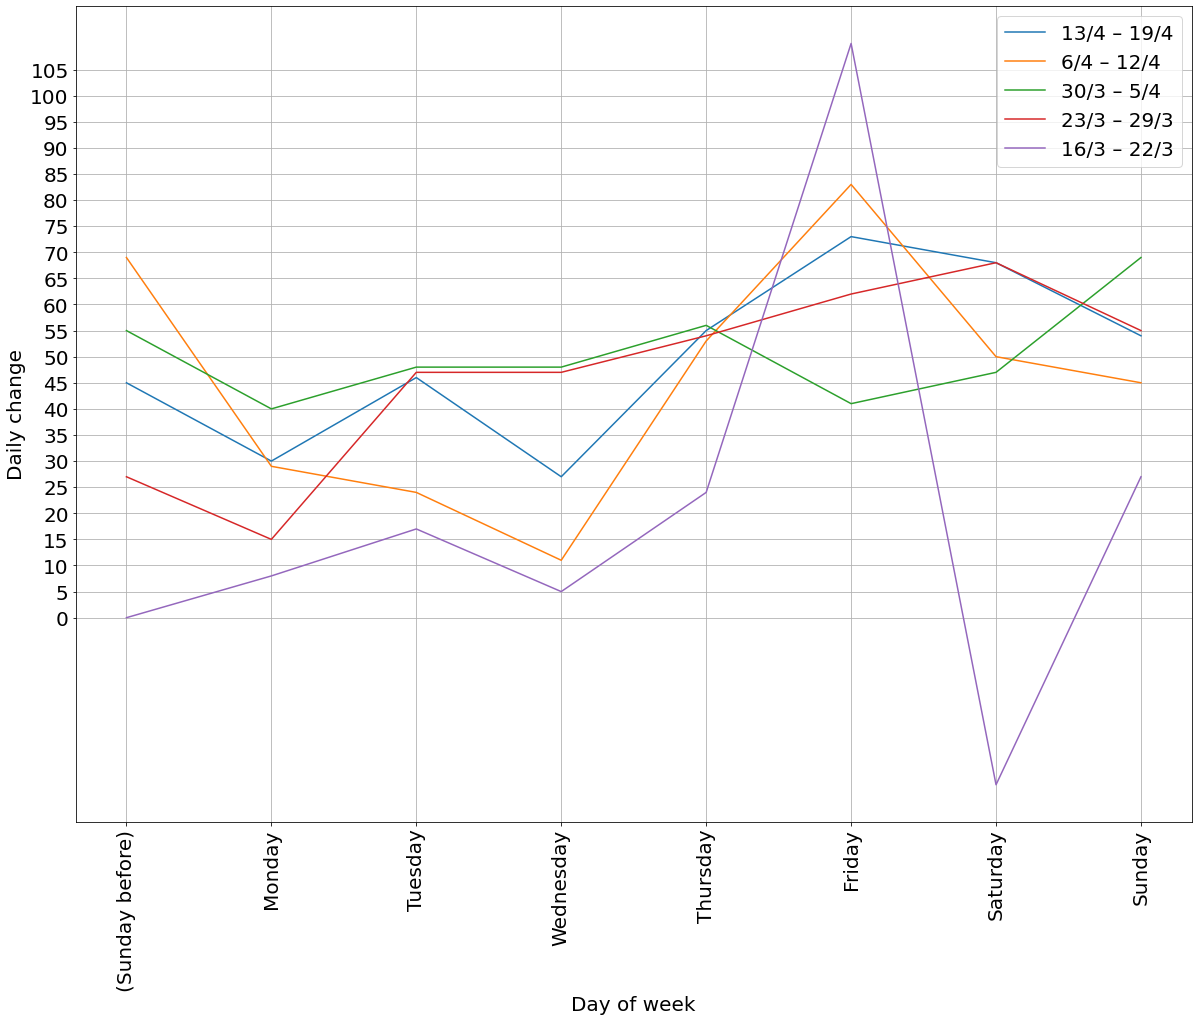

,Date_of_report,Week,Daily_delta,Total_reported
11486,2020-04-13,16,30,1212
11853,2020-04-14,16,46,1258
12220,2020-04-15,16,27,1285
12587,2020-04-16,16,55,1340
12954,2020-04-17,16,73,1413
13321,2020-04-18,16,68,1481
13688,2020-04-19,16,54,1535


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week change in reported cases

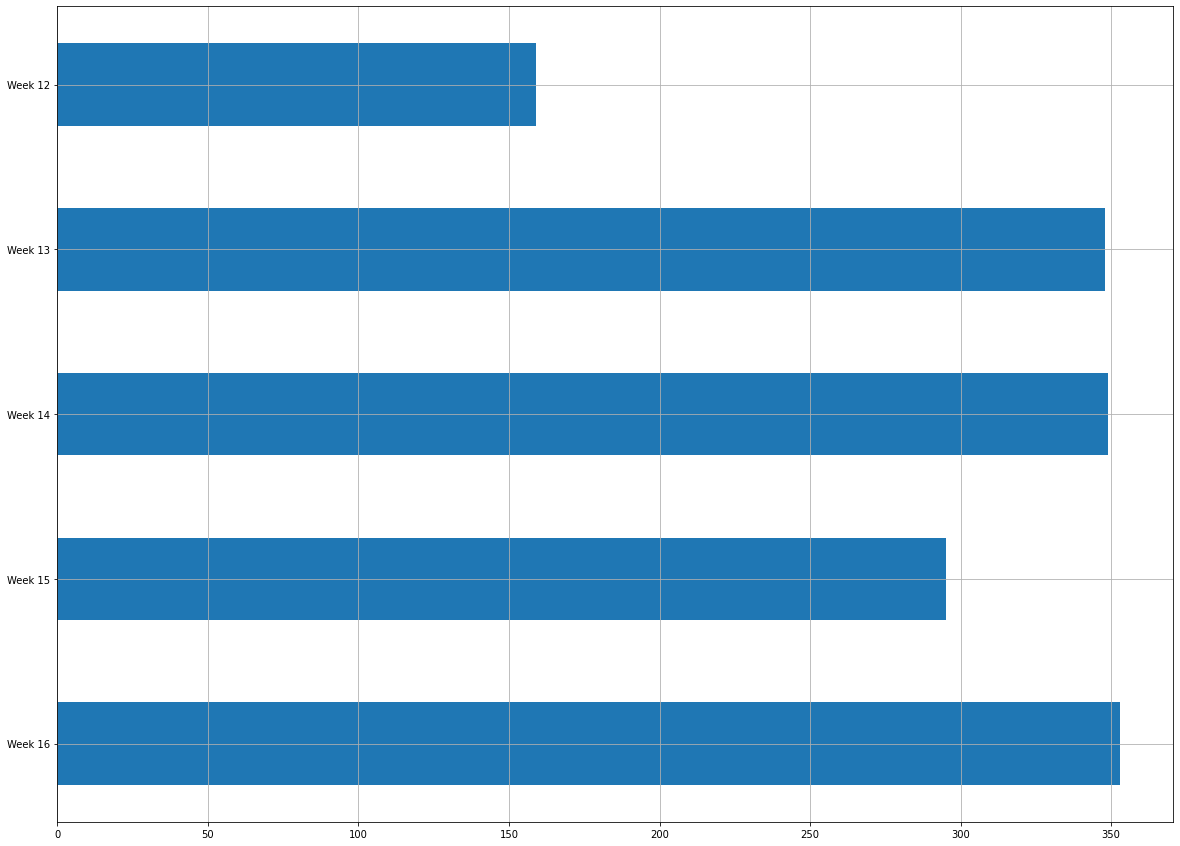

{'Week 12': 159, 'Week 13': 348, 'Week 14': 349, 'Week 15': 295, 'Week 16': 353}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
def weekly_percentage_incr_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,float]:
    weekly_percent_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(
                f"Week no. {df['Week'].max() - week} does not exist."
            )
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[
            df["Week"] == this_week_num
        ]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_percent_delta[
                f"Week {this_week_num}"] = 0
            continue
        else:
            last_week_delta = df[
                df["Week"] == (this_week_num-1)
            ]["Daily_delta"].sum()

            weekly_percent_delta[f"Week {this_week_num}"] = \
                ((week_delta-last_week_delta)/last_week_delta)*100

    return weekly_percent_delta

### Plot week-on-week percentage change in reported cases

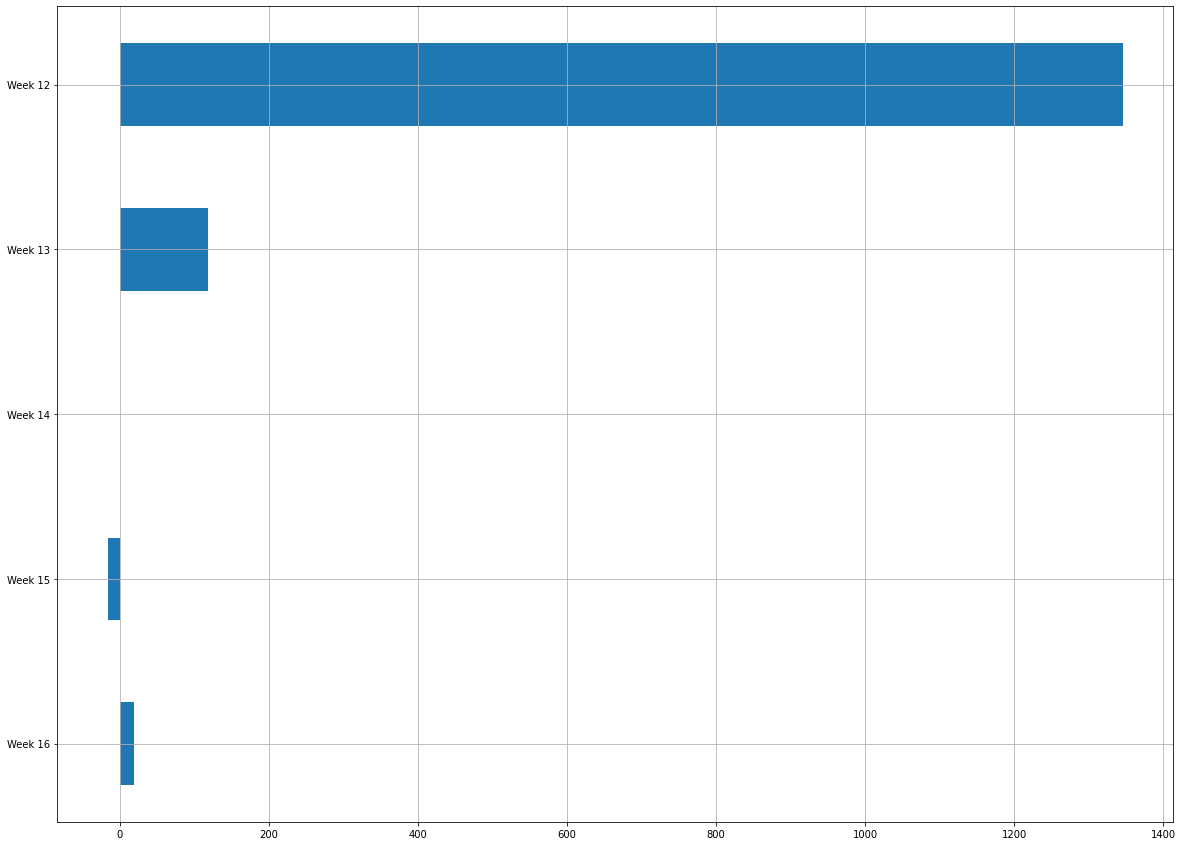

{'Week 12': 1345.4545454545455,
 'Week 13': 118.86792452830188,
 'Week 14': 0.28735632183908044,
 'Week 15': -15.472779369627506,
 'Week 16': 19.661016949152543}


In [10]:
plt.grid(True)
weekly_percent_delta = \
    weekly_percentage_incr_for_last_n_weeks(cumuldf,5)
plt.barh(
    list(weekly_percent_delta.keys()),
    width=np.array(list(weekly_percent_delta.values())),
    height=0.5)
plt.show()
pprint(weekly_percent_delta)

In [11]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 7 days

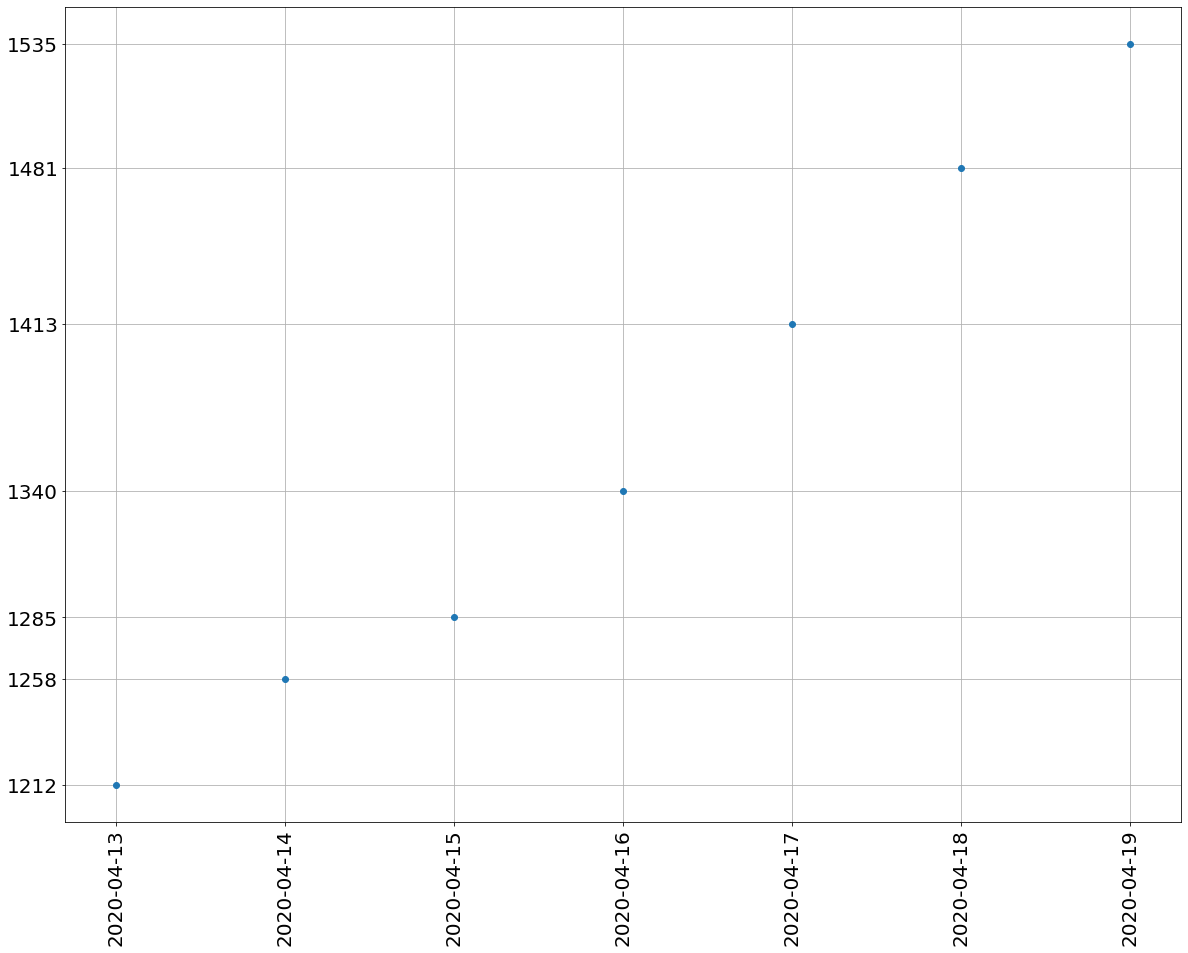

      Date_of_report  Total_reported
11486     2020-04-13            1212
11853     2020-04-14            1258
12220     2020-04-15            1285
12587     2020-04-16            1340
12954     2020-04-17            1413
13321     2020-04-18            1481
13688     2020-04-19            1535


In [12]:
plot_cumul_reported_last_n_days(cumuldf, 7, "Total_reported")

### Cumulative reported cases for the last 14 days

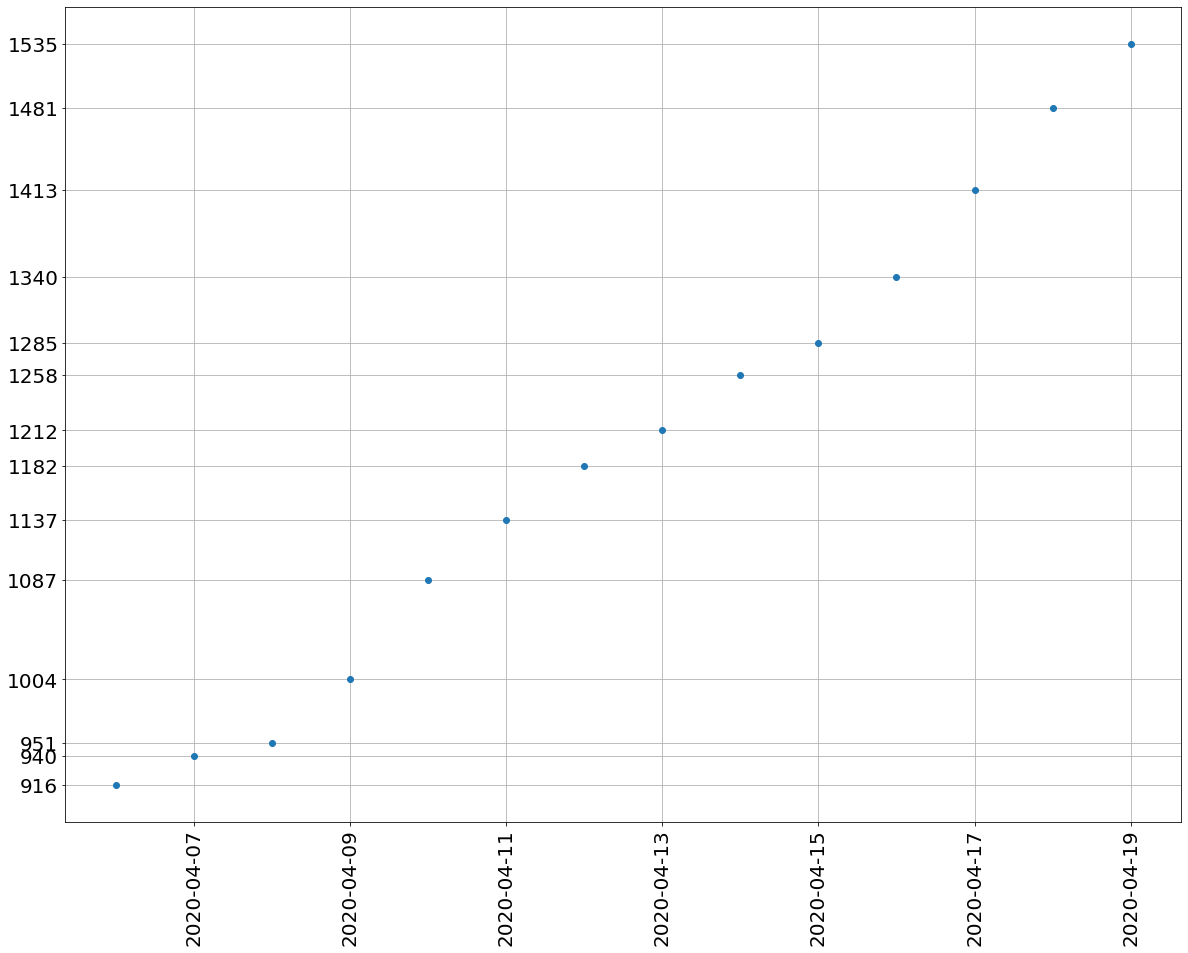

      Date_of_report  Total_reported
8917      2020-04-06             916
9284      2020-04-07             940
9651      2020-04-08             951
10018     2020-04-09            1004
10385     2020-04-10            1087
10752     2020-04-11            1137
11119     2020-04-12            1182
11486     2020-04-13            1212
11853     2020-04-14            1258
12220     2020-04-15            1285
12587     2020-04-16            1340
12954     2020-04-17            1413
13321     2020-04-18            1481
13688     2020-04-19            1535


In [13]:
plot_cumul_reported_last_n_days(cumuldf, 14, "Total_reported")

### Cumulative reported cases for the last 30 days

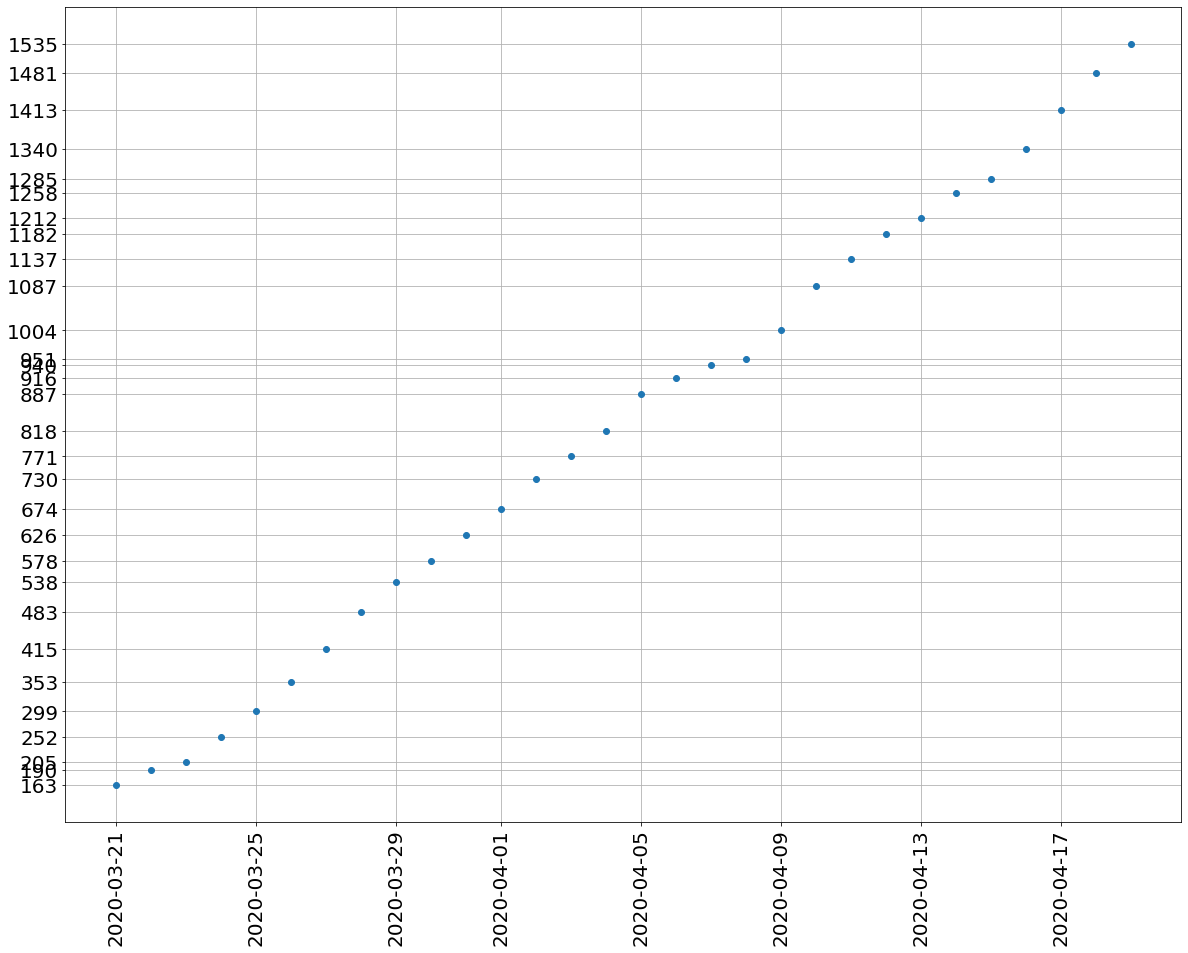

      Date_of_report  Total_reported
3045      2020-03-21             163
3412      2020-03-22             190
3779      2020-03-23             205
4146      2020-03-24             252
4513      2020-03-25             299
4880      2020-03-26             353
5247      2020-03-27             415
5614      2020-03-28             483
5981      2020-03-29             538
6348      2020-03-30             578
6715      2020-03-31             626
7082      2020-04-01             674
7449      2020-04-02             730
7816      2020-04-03             771
8183      2020-04-04             818
8550      2020-04-05             887
8917      2020-04-06             916
9284      2020-04-07             940
9651      2020-04-08             951
10018     2020-04-09            1004
10385     2020-04-10            1087
10752     2020-04-11            1137
11119     2020-04-12            1182
11486     2020-04-13            1212
11853     2020-04-14            1258
12220     2020-04-15            1285
1

In [14]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

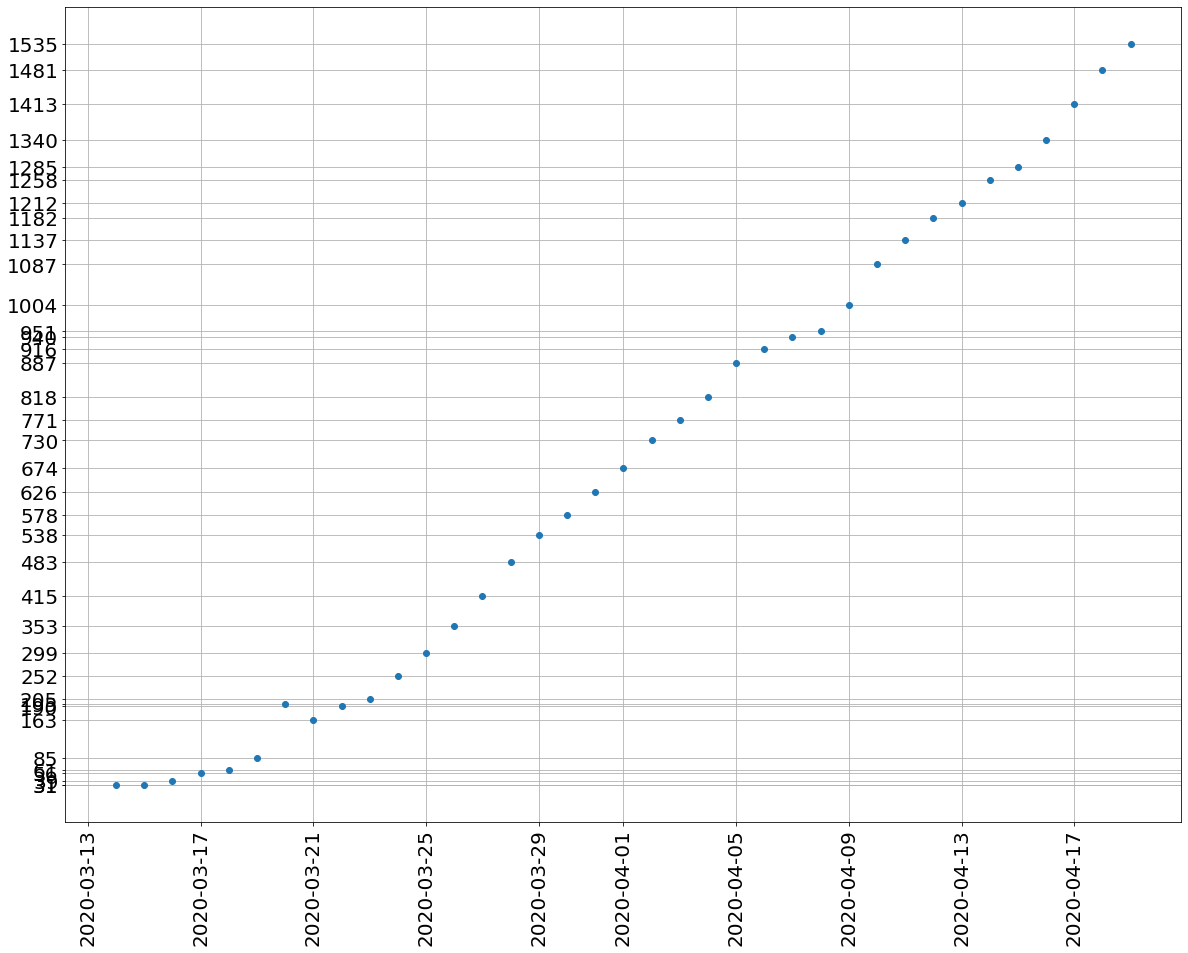

      Date_of_report  Total_reported
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
1944      2020-03-18              61
2311      2020-03-19              85
2678      2020-03-20             195
3045      2020-03-21             163
3412      2020-03-22             190
3779      2020-03-23             205
4146      2020-03-24             252
4513      2020-03-25             299
4880      2020-03-26             353
5247      2020-03-27             415
5614      2020-03-28             483
5981      2020-03-29             538
6348      2020-03-30             578
6715      2020-03-31             626
7082      2020-04-01             674
7449      2020-04-02             730
7816      2020-04-03             771
8183      2020-04-04             818
8550      2020-04-05             887
8917      2020-04-06             916
9284      2020-04-07             940
9651      2020-04-08             951
1

In [15]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Hospitalization daily delta for last 30 days

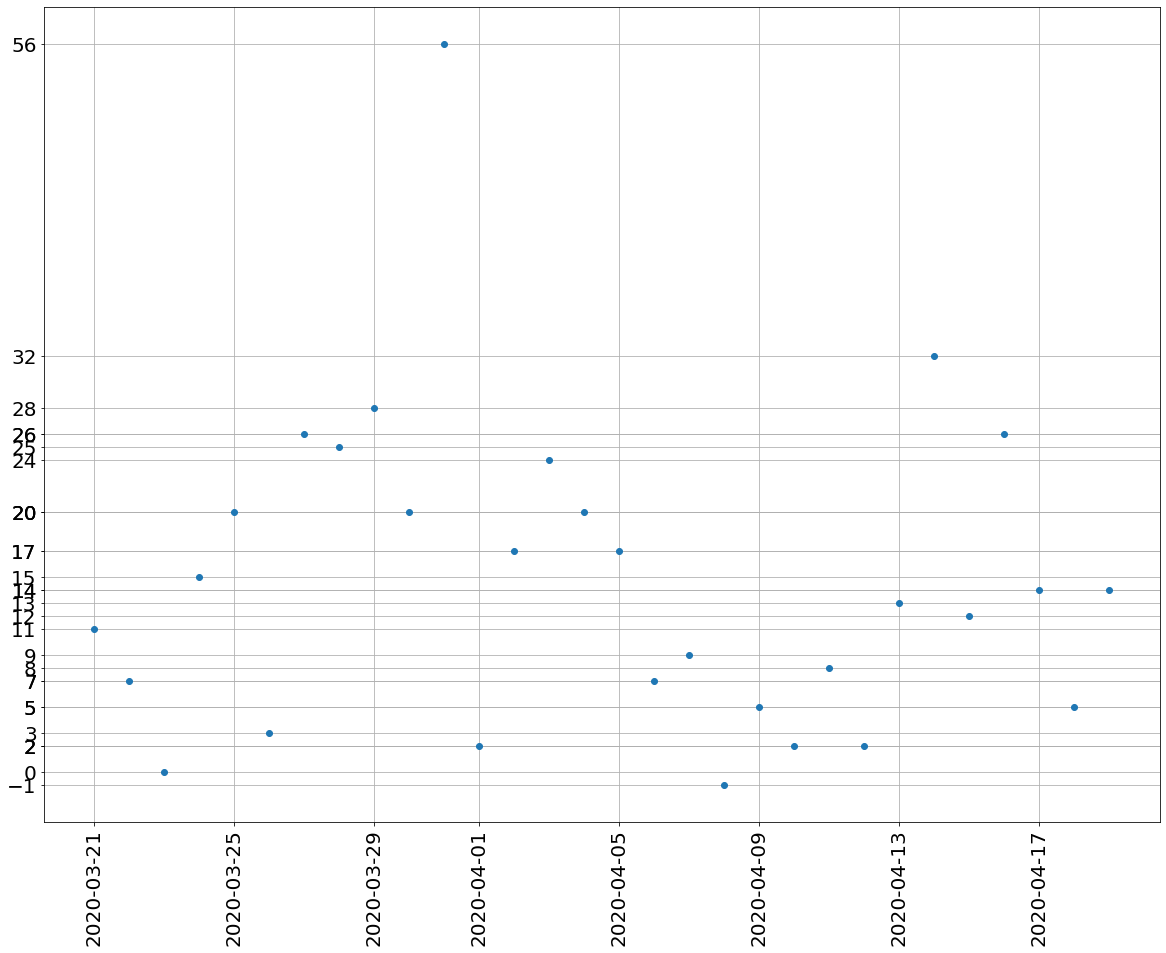

      Date_of_report  Hospital_delta
3045      2020-03-21              11
3412      2020-03-22               7
3779      2020-03-23               0
4146      2020-03-24              15
4513      2020-03-25              20
4880      2020-03-26               3
5247      2020-03-27              26
5614      2020-03-28              25
5981      2020-03-29              28
6348      2020-03-30              20
6715      2020-03-31              56
7082      2020-04-01               2
7449      2020-04-02              17
7816      2020-04-03              24
8183      2020-04-04              20
8550      2020-04-05              17
8917      2020-04-06               7
9284      2020-04-07               9
9651      2020-04-08              -1
10018     2020-04-09               5
10385     2020-04-10               2
10752     2020-04-11               8
11119     2020-04-12               2
11486     2020-04-13              13
11853     2020-04-14              32
12220     2020-04-15              12
1

In [16]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_delta")

### Cumulative hospitalizations for last 30 days

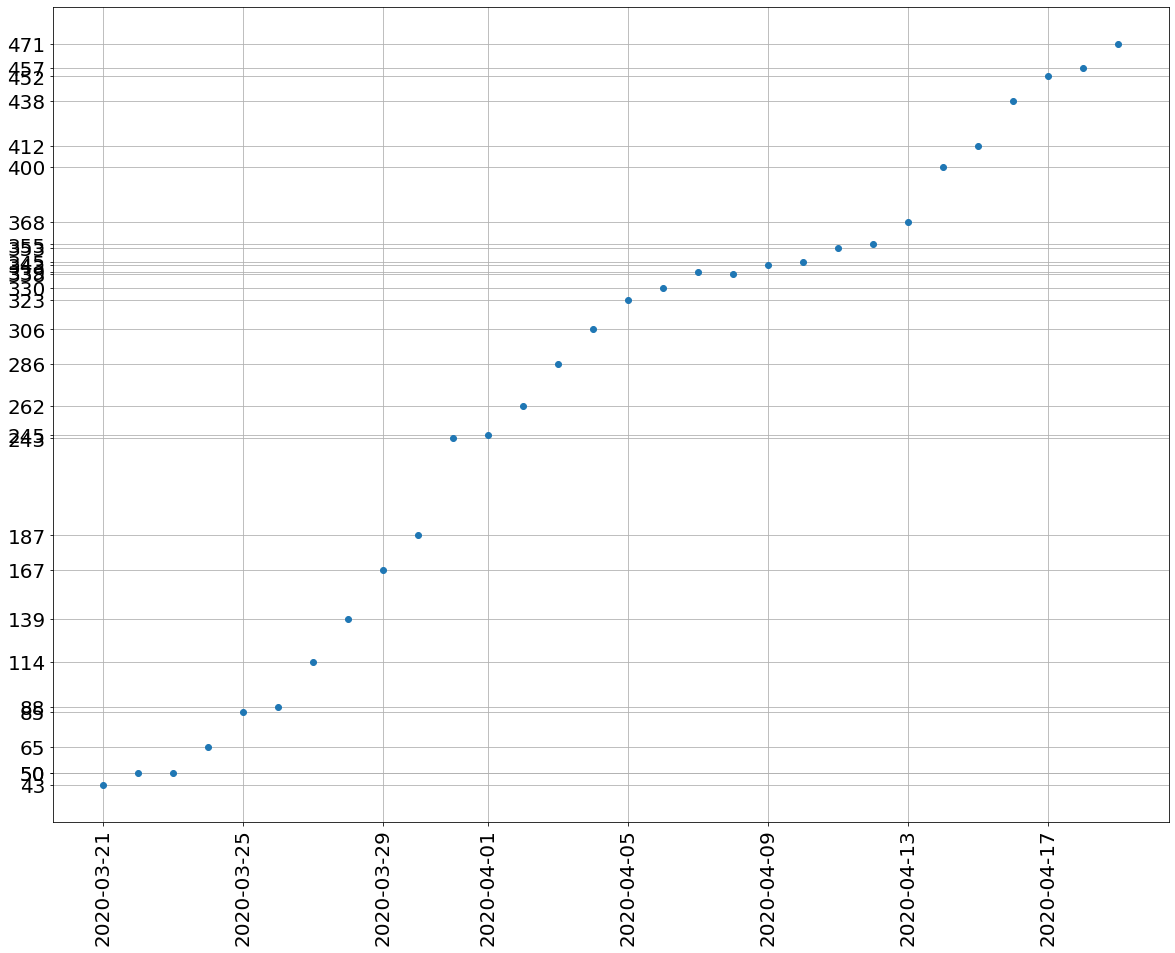

      Date_of_report  Hospital_admission
3045      2020-03-21                  43
3412      2020-03-22                  50
3779      2020-03-23                  50
4146      2020-03-24                  65
4513      2020-03-25                  85
4880      2020-03-26                  88
5247      2020-03-27                 114
5614      2020-03-28                 139
5981      2020-03-29                 167
6348      2020-03-30                 187
6715      2020-03-31                 243
7082      2020-04-01                 245
7449      2020-04-02                 262
7816      2020-04-03                 286
8183      2020-04-04                 306
8550      2020-04-05                 323
8917      2020-04-06                 330
9284      2020-04-07                 339
9651      2020-04-08                 338
10018     2020-04-09                 343
10385     2020-04-10                 345
10752     2020-04-11                 353
11119     2020-04-12                 355
11486     2020-0

In [17]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")